In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tumor detection models : Yolov8

# Table of Contents:
* [Explore and Visulaze Training Data](#chapter1)
* [Tumor Detection With Yolo8](#chapter5)
    * Implement Model
    * Training Model with Tumor Dataset
    * Model evaluation  
* [Conclusion  ](#chapter5)  

In [2]:
from IPython.display import clear_output

In [3]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install tensorflow
#!pip install seaborn
!pip install -U ultralytics
!pip install pybboxes
!pip install segmentation-models
clear_output()

# Imports  <a class="anchor" id="section1"></a>

In [4]:
#import some necessary librairies
import os
import os.path
from pathlib import Path
import glob
import warnings
import shutil
import itertools
from warnings import filterwarnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore all warning  message from librairies

# linear algebra
import numpy as np
# data processing
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import load_model

In [5]:
from tqdm import tqdm
from google.colab.patches import cv2_imshow

### Configs

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#set seed to 42
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

%matplotlib inline
sns.set_theme()


os.environ['SM_FRAMEWORK'] = 'tf.keras'
tf.config.run_functions_eagerly(True)
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


# CONSTANTS

In [32]:
PROJECT_NAME = "Yolov8 Tumor Detection" #just for project title
RANDOM_SEED = 42
IMAGE_SIZE = (640,640)
SAMPLE_NUMBER = 0
# Batch size for training
BATCH_SIZE = 16
# Training Epochs
EPOCHS = 60
CHANNEL= 3
USE_PRETRAINED = True
# Filters for pretrained models
#FILTER_LIST = [ 32,64,128 ]

In [38]:
MAIN_PROJECT_PATH=  "/content/drive/MyDrive/projects/my_final_project/03_yolov8_detection_model"
PRETRAINED_MODEL_PATH =    MAIN_PROJECT_PATH+'/runs/detect/yolov8n_finetuned/weights/best.pt'

In [9]:
YOLO_DATASET_PATH = "/content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/"
val_images_dir=YOLO_DATASET_PATH+"valid/images"
val_labels_dir=YOLO_DATASET_PATH+"valid/labels"

In [10]:
yaml_file= f"""path: {YOLO_DATASET_PATH}
train: 'train/images'
val:   'valid/images'
test: 'test/images'

nc: 3
names: ['Glioma', 'Meningioma', 'Pituitary']
"""
with open("dataset.yaml","w") as f :
  f.write(yaml_file)

In [39]:
if USE_PRETRAINED:
  %load_ext tensorboard
  %tensorboard --logdir runs/detect/yolov8n_finetuned
else:
  path_to_logs =MAIN_PROJECT_PATH+'/runs/detect/yolov8n_finetuned'
  %load_ext tensorboard
  %tensorboard --logdir path_to_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-12-04 13:04:09.261296: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 13:04:09.261379: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 13:04:09.261414: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that pr

In [12]:
from ultralytics import YOLO

if not USE_PRETRAINED:
    model = YOLO('yolov8n.yaml')
    # Training.
    results = model.train(
      data='dataset.yaml',
      imgsz=640,
      epochs=EPOCHS,
      batch=BATCH_SIZE,
      name='yolov8n_finetuned')
else:
   model=YOLO(PRETRAINED_MODEL_PATH)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 54.0MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    751897  ultralytics.nn.modules.head.Detect           [3, [64, 128, 256]]           
YOLOv8n summary: 225 layers, 3011433 parameters, 3011417 gradients, 8.2 GFLOPs

TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov8n_finetuned', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 172MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/train/labels.cache... 2810 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2810/2810 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/train/images/1043_png.rf.63ebd980b1821e113343bc4cc9f685e1.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/train/images/1044_png.rf.7ccad20460adb5a46f0f1ab9cb70e8c9.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/train/images/1045_png.rf.1e2ea63331eec58975cedfd7ecf557a4.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/train/images/1046_png.rf.198d9ae6042fa848d4c71fb1632e681b.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/train/images/1047_png.rf.2a2e67feb292bc05a0db20730a0974a4.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/train/images/104

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/labels.cache... 203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 203/203 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2020_png.rf.61a66efb749331bdac56346e44ca5f50.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2021_png.rf.5cd6eae0992324aa37a36c7981806d5d.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2022_png.rf.2427cbeb89c097f7029e633dcf5d6ea4.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2023_png.rf.6d719b9c88bf976ca7c74eccae578bd5.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2024_png.rf.fae606ade6fc791603be2a560792976c.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2025_png.rf.e09

Plotting labels to runs/detect/yolov8n_finetuned/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_finetuned
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      2.55G      3.382      5.449      3.782         11        640: 100%|██████████| 176/176 [20:32<00:00,  7.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.35s/it]

                   all        203        203    0.00663      0.142    0.00474    0.00135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      2.54G      2.632      3.758      2.685         22        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


                   all        203        203      0.435     0.0996      0.181     0.0524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.55G      2.182      2.655      2.312         19        640: 100%|██████████| 176/176 [02:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        203        203      0.283      0.218      0.154     0.0864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.55G      1.897      2.152      2.099         15        640: 100%|██████████| 176/176 [02:13<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]

                   all        203        203      0.564      0.463      0.466      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      2.55G      1.812      1.966      2.024          9        640: 100%|██████████| 176/176 [02:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        203        203      0.641      0.433      0.479      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.55G      1.721      1.854      1.954         11        640: 100%|██████████| 176/176 [02:13<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


                   all        203        203      0.402       0.34      0.325      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.55G      1.676      1.762      1.899         12        640: 100%|██████████| 176/176 [02:18<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]

                   all        203        203      0.682      0.477      0.545      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.55G      1.619      1.649      1.841         16        640: 100%|██████████| 176/176 [02:29<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]

                   all        203        203      0.633      0.514      0.577      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.55G      1.597      1.628      1.828         12        640: 100%|██████████| 176/176 [02:33<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


                   all        203        203      0.537      0.614      0.586       0.37

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.55G      1.563      1.556      1.799         17        640: 100%|██████████| 176/176 [02:31<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


                   all        203        203      0.586      0.588      0.568      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      2.55G      1.516      1.472       1.75         11        640: 100%|██████████| 176/176 [02:32<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]

                   all        203        203       0.66       0.63      0.694       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.55G       1.47       1.43      1.713         12        640: 100%|██████████| 176/176 [02:30<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        203        203      0.574      0.645      0.639      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.55G      1.492      1.403      1.722         17        640: 100%|██████████| 176/176 [02:29<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]

                   all        203        203      0.596      0.592      0.616        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      2.55G      1.472       1.37      1.699         17        640: 100%|██████████| 176/176 [02:28<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


                   all        203        203      0.693      0.577      0.664      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      2.55G      1.444      1.324      1.694         18        640: 100%|██████████| 176/176 [02:14<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

                   all        203        203      0.652      0.585      0.666      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      2.55G      1.454      1.294      1.676         13        640: 100%|██████████| 176/176 [02:29<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.00it/s]

                   all        203        203      0.758      0.614      0.695      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      2.55G      1.415      1.279      1.653         12        640: 100%|██████████| 176/176 [02:28<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        203        203     0.0397      0.679     0.0385     0.0206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      2.55G      1.408      1.271      1.645         17        640: 100%|██████████| 176/176 [02:29<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        203        203      0.688      0.587      0.681       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      2.55G      1.407      1.247      1.646         22        640: 100%|██████████| 176/176 [02:28<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]

                   all        203        203      0.683      0.645      0.687      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      2.55G      1.369      1.186      1.616         20        640: 100%|██████████| 176/176 [02:30<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        203        203      0.714      0.563      0.672      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      2.55G      1.353       1.19      1.603         10        640: 100%|██████████| 176/176 [02:32<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        203        203      0.671      0.615      0.679      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      2.55G      1.374      1.162      1.616         15        640: 100%|██████████| 176/176 [02:31<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]

                   all        203        203      0.755      0.625      0.699      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      2.55G       1.34       1.15        1.6         17        640: 100%|██████████| 176/176 [02:17<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


                   all        203        203      0.581      0.528      0.593      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      2.55G      1.359      1.137      1.587         12        640: 100%|██████████| 176/176 [02:32<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


                   all        203        203      0.661      0.674      0.719      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      2.55G      1.328      1.096      1.579         21        640: 100%|██████████| 176/176 [02:32<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.40it/s]


                   all        203        203      0.707      0.648      0.733      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      2.55G      1.337      1.113      1.578         15        640: 100%|██████████| 176/176 [02:33<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


                   all        203        203      0.732       0.65      0.698      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      2.55G      1.302      1.081      1.558          7        640: 100%|██████████| 176/176 [02:32<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        203        203      0.706      0.706      0.742      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      2.55G      1.282      1.059      1.534         19        640: 100%|██████████| 176/176 [02:30<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

                   all        203        203      0.725       0.63      0.699       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      2.55G      1.287      1.061      1.549         16        640: 100%|██████████| 176/176 [02:30<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

                   all        203        203      0.749      0.681      0.748      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      2.55G      1.292      1.063      1.538         17        640: 100%|██████████| 176/176 [02:31<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        203        203      0.665      0.634       0.66      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      2.55G      1.276      1.027       1.53         16        640: 100%|██████████| 176/176 [02:13<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        203        203      0.641      0.709      0.725      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      2.55G      1.265      1.001      1.517         24        640: 100%|██████████| 176/176 [02:16<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        203        203      0.664      0.743       0.77      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      2.55G      1.239     0.9594      1.507         23        640: 100%|██████████| 176/176 [02:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        203        203      0.714       0.63      0.688      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      2.55G      1.259     0.9982      1.516         13        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        203        203      0.685      0.711       0.76      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      2.55G      1.235     0.9609      1.504         13        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


                   all        203        203       0.64      0.706      0.679      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      2.55G      1.252     0.9553      1.502         13        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        203        203      0.711      0.675      0.721      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      2.55G      1.212     0.9311       1.48         13        640: 100%|██████████| 176/176 [02:09<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]

                   all        203        203      0.605      0.689      0.699      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      2.55G      1.201     0.9248       1.48         18        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]

                   all        203        203      0.667      0.765      0.767      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      2.55G      1.205     0.9111      1.481         10        640: 100%|██████████| 176/176 [02:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        203        203      0.616      0.722      0.731      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      2.55G      1.216     0.9176      1.486         20        640: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        203        203      0.714      0.727       0.79      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      2.55G      1.177     0.8778      1.456         13        640: 100%|██████████| 176/176 [02:11<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

                   all        203        203      0.661      0.751      0.721      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      2.55G      1.197     0.8989      1.474          9        640: 100%|██████████| 176/176 [02:12<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        203        203       0.69      0.698      0.722      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      2.55G      1.181     0.8854      1.461         17        640: 100%|██████████| 176/176 [02:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        203        203      0.775      0.702      0.781      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      2.55G      1.181     0.8647      1.468          9        640: 100%|██████████| 176/176 [02:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        203        203      0.705       0.73      0.783      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      2.55G      1.173     0.8698      1.442         15        640: 100%|██████████| 176/176 [02:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        203        203      0.678      0.797      0.799      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      2.55G      1.151     0.8517      1.438          9        640: 100%|██████████| 176/176 [02:11<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]

                   all        203        203      0.701      0.746       0.79      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      2.55G       1.15     0.8462      1.422         19        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]

                   all        203        203      0.677      0.812      0.799      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      2.55G       1.15     0.8157      1.423         11        640: 100%|██████████| 176/176 [02:11<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]

                   all        203        203      0.749      0.719      0.791      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      2.55G      1.132      0.829      1.409         19        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        203        203      0.711       0.74      0.797      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      2.55G      1.125     0.8236      1.406         17        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]

                   all        203        203      0.685      0.773      0.813      0.579


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      2.55G       1.06     0.7232      1.432         10        640: 100%|██████████| 176/176 [02:10<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        203        203      0.746       0.76      0.808      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      2.55G      1.029     0.6837      1.414         10        640: 100%|██████████| 176/176 [02:07<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        203        203      0.717      0.761      0.808      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      2.55G      1.021     0.6687      1.395         10        640: 100%|██████████| 176/176 [02:07<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        203        203      0.679      0.778      0.803      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      2.55G      1.008     0.6578       1.39         10        640: 100%|██████████| 176/176 [02:05<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        203        203      0.802      0.729      0.817      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      2.55G     0.9906     0.6324      1.381         10        640: 100%|██████████| 176/176 [02:06<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        203        203      0.789      0.747      0.809      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      2.55G     0.9889      0.626      1.376         10        640: 100%|██████████| 176/176 [02:08<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        203        203      0.733      0.775      0.816      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      2.55G     0.9768     0.6151      1.374         10        640: 100%|██████████| 176/176 [02:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]

                   all        203        203      0.746       0.77      0.818      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      2.55G     0.9627     0.6147      1.352         10        640: 100%|██████████| 176/176 [02:08<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]

                   all        203        203      0.792      0.761       0.82      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      2.55G      0.962     0.6047      1.358         10        640: 100%|██████████| 176/176 [02:09<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        203        203      0.779      0.764      0.822      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      2.55G     0.9449     0.5923      1.334         10        640: 100%|██████████| 176/176 [02:18<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]

                   all        203        203      0.767      0.759      0.818      0.579



60 epochs completed in 2.732 hours.
Optimizer stripped from runs/detect/yolov8n_finetuned/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_finetuned/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_finetuned/weights/best.pt...
Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.14s/it]


                   all        203        203        0.8      0.729      0.818      0.583
                Glioma        203        171      0.842       0.52      0.711      0.426
            Meningioma        203         32      0.758      0.938      0.925      0.741
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/yolov8n_finetuned


# Evaluation model on Test Data

In [25]:
sample_1=  YOLO_DATASET_PATH+"valid/images/2095_png.rf.4bc0cde0532e58080addd09486fc4153.jpg"
sample_2=  YOLO_DATASET_PATH+"valid/images/218_png.rf.fb1d030bab9d7fc8aea2d7e19db7cb3c.jpg"
sample_3=  YOLO_DATASET_PATH+"valid/images/855_png.rf.e3ad6e7a65abb542599af8ef0bbb281c.jpg"

### Visulize Trained Models Prediction on Validation images

In [22]:
def get_image_file_annotation(image_item,dataset_path,file_name):
    import pybboxes as pbx

    points_scaled=None
    full_p = os.path.join(dataset_path.replace("images","labels"),file_name[:-3]+"txt")

    classes = []
    with open(full_p,"r") as f:
      #(x, y, w, h )
      classes =f.read().split("\n")
      for cls in classes:
          yolo_bbox1 =   list(map(float, cls.split(" ")))
          H, W = image_item.shape[:2]
          yolo_bbox1 =yolo_bbox1[1:]
          box_voc=pbx.convert_bbox(yolo_bbox1, from_type="yolo", to_type="voc", image_size=(W, H))
          fname =file_name
          dimensions = image_item.shape
          output_mask=cv2.rectangle(image_item,
                                      (box_voc[0], box_voc[1]),
                                      (box_voc[2], box_voc[3]),
                                      (0, 255, 0), 2)

    return output_mask


### Samples real bbox vs prediction

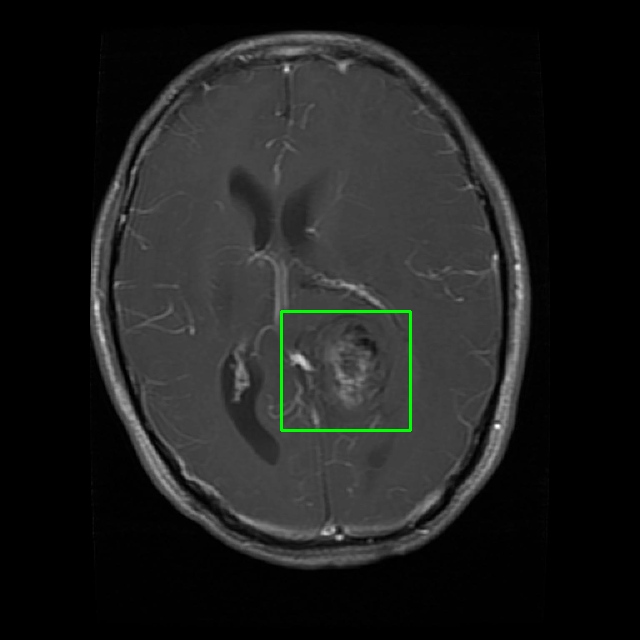

In [23]:
img_sample_1 = cv2.imread(sample_1)
img_sample_1=  cv2.resize(img_sample_1,(640,640))
cv2_imshow(get_image_file_annotation(img_sample_1,val_images_dir,sample_1.split("/")[-1]))


image 1/1 /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2095_png.rf.4bc0cde0532e58080addd09486fc4153.jpg: 640x640 1 Glioma, 71.8ms
Speed: 16.7ms preprocess, 71.8ms inference, 26.6ms postprocess per image at shape (1, 3, 640, 640)


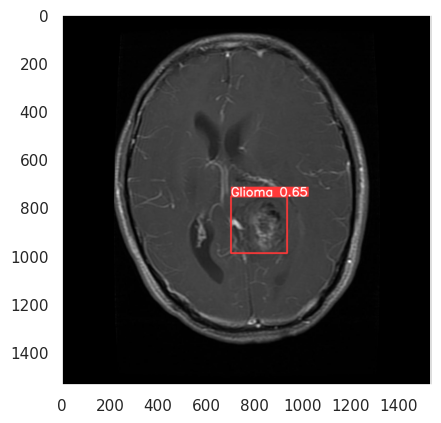

In [85]:
results1 = model(sample_1)  # results list
# Show the results
plt.grid(False)
for r in results1:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im) # show image


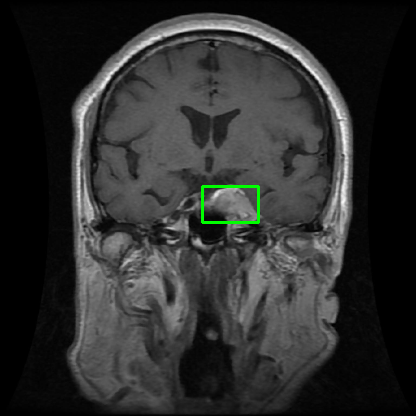

In [26]:
img_sample_2 = cv2.imread(sample_2)
img_sample_2=  cv2.resize(img_sample_2,(416,416))
cv2_imshow(get_image_file_annotation(img_sample_2,val_images_dir,sample_2.split("/")[-1]))


image 1/1 /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/218_png.rf.fb1d030bab9d7fc8aea2d7e19db7cb3c.jpg: 640x640 1 Meningioma, 28.8ms
Speed: 12.9ms preprocess, 28.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


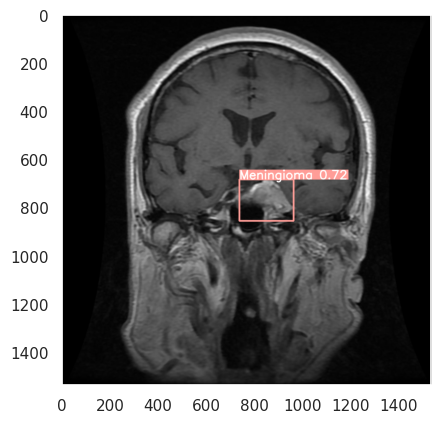

In [86]:
results1 = model(sample_2)  # results list
# Show the results
plt.grid(False)
for r in results1:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im) # show image


### Model Evaluations:

##### Model Confusion Matrix

In [40]:
PLOTS_PATH = ""
if USE_PRETRAINED:
  PLOTS_PATH=MAIN_PROJECT_PATH+'/runs/detect/yolov8n_finetuned/'
else:
  PLOTS_PATH= '/runs/detect/yolov8n_finetuned/'

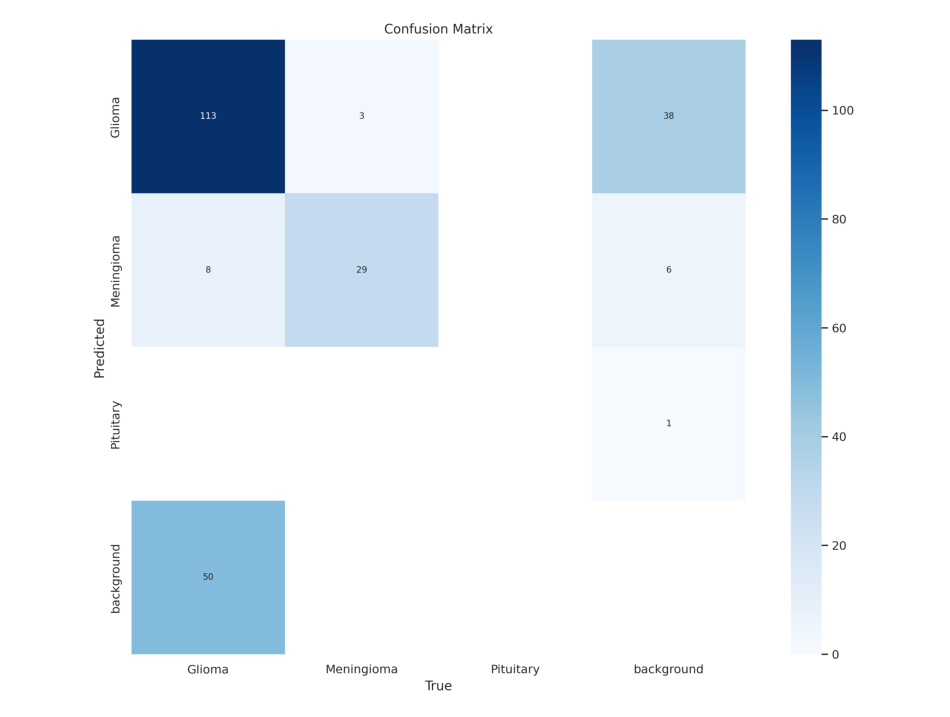

In [43]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"confusion_matrix.png"))

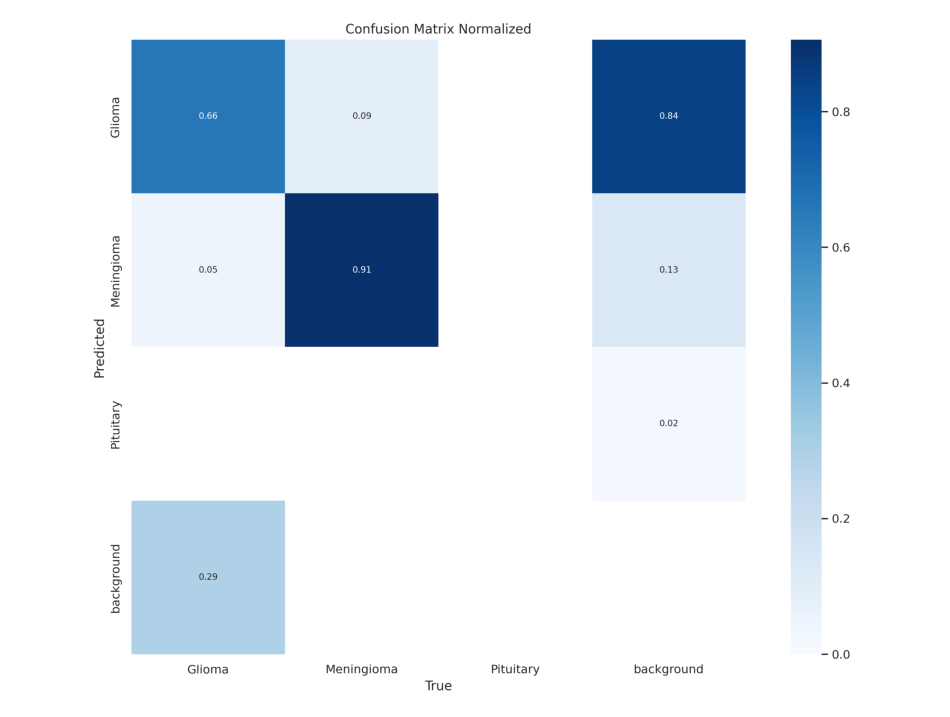

In [44]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"confusion_matrix_normalized.png"))

##### Model Percesion

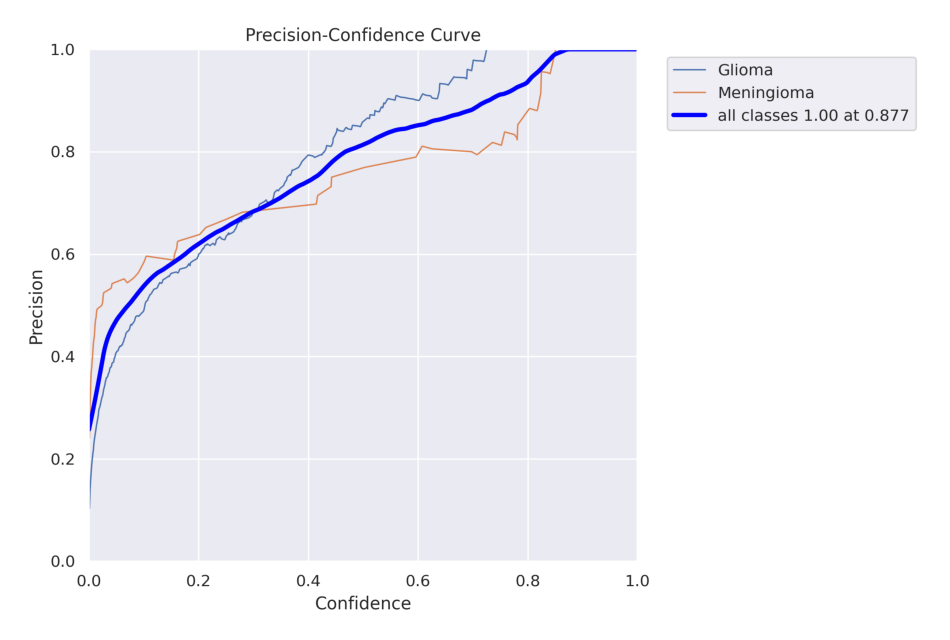

In [45]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"P_curve.png"))

##### Model Recal

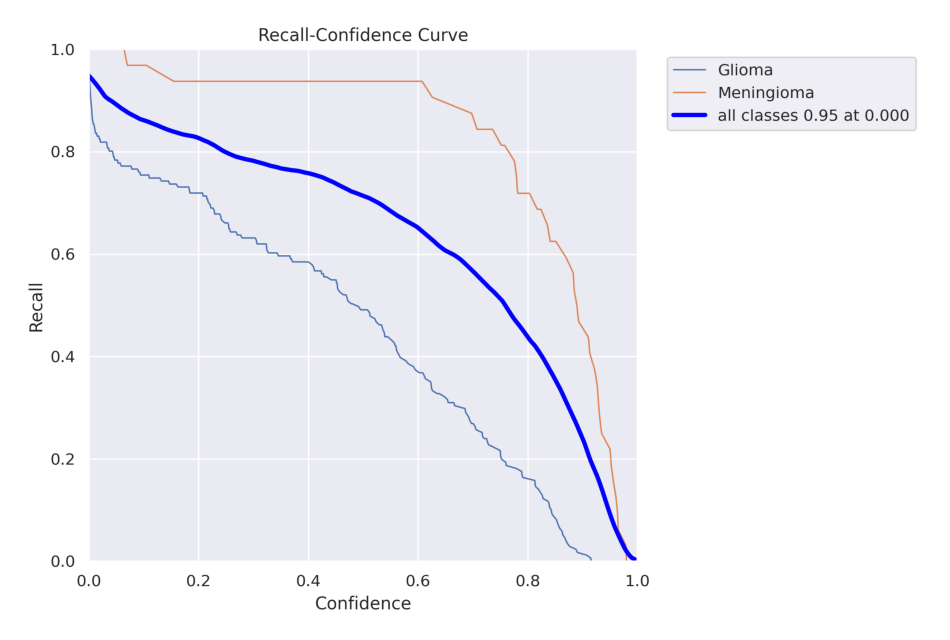

In [46]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"R_curve.png"))

##### Model F1 Score

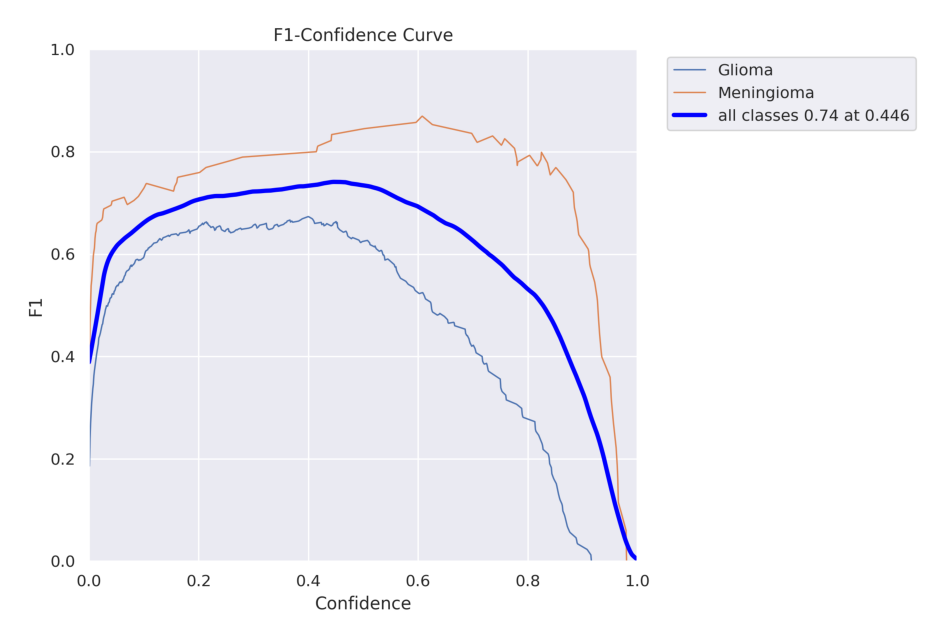

In [47]:
plt.figure(figsize=(12,12))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"F1_curve.png"))

##### Model Results

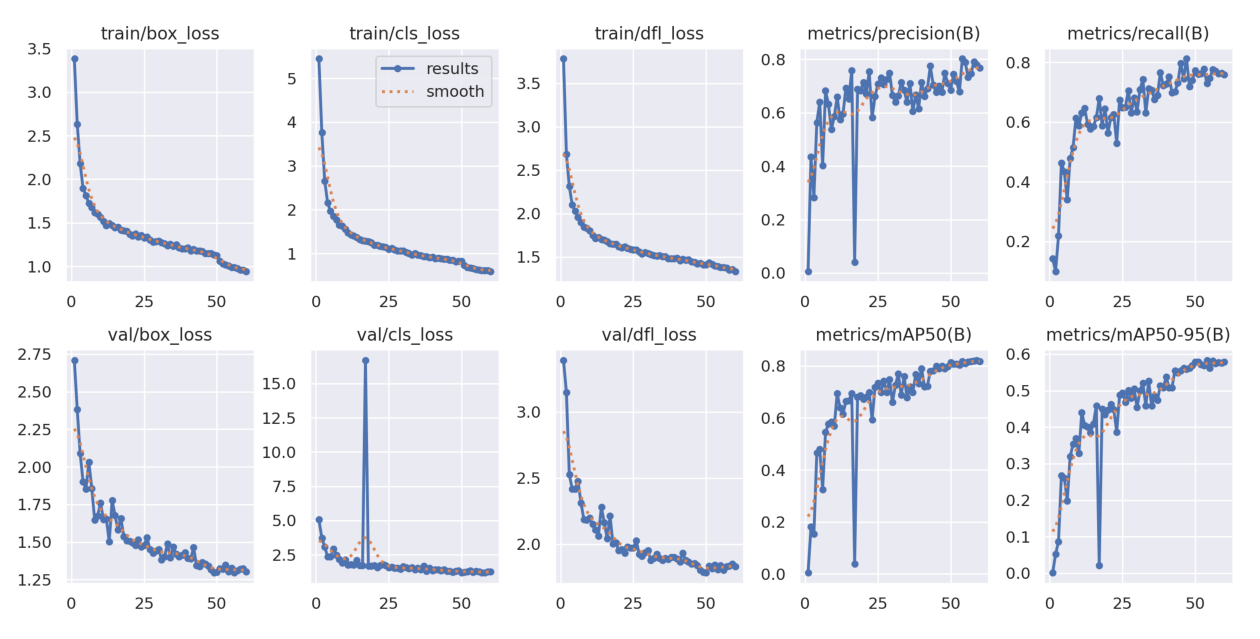

In [48]:
plt.figure(figsize=(16,10))
plt.grid(False)
plt.axis("off")
plt.imshow(plt.imread(PLOTS_PATH+"results.png"))

In [52]:
results = model.val()

Ultralytics YOLOv8.0.222 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/labels.cache... 203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 203/203 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2020_png.rf.61a66efb749331bdac56346e44ca5f50.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2021_png.rf.5cd6eae0992324aa37a36c7981806d5d.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2022_png.rf.2427cbeb89c097f7029e633dcf5d6ea4.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2023_png.rf.6d719b9c88bf976ca7c74eccae578bd5.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2024_png.rf.fae606ade6fc791603be2a560792976c.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/projects/my_final_project/datasets/yolo_dataset/valid/images/2025_png.rf.e09


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:14<00:00,  1.14s/it]


                   all        203        203      0.812      0.729      0.818      0.583
                Glioma        203        171      0.846       0.52      0.711      0.426
            Meningioma        203         32      0.778      0.938      0.925      0.741
Speed: 0.6ms preprocess, 11.5ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/yolov8n_finetuned


In [59]:
class_names_dict ={0:'Glioma', 1:'Meningioma', 2:'Pituitary'}

In [60]:
import pandas as pd

class_names = list(results.names)
metrics_dict = {}
for class_name in class_names:
  try:
    class_index = class_names.index(class_name)
    precision = results.box.class_result(class_index)[0]
    recall = results.box.class_result(class_index)[1]
    f1_score = results.box.class_result(class_index)[2]
    class_real_name  = class_names_dict[class_name]
    metrics_dict[class_real_name] = {'Precision': precision, 'Recall': recall, 'F1-score': f1_score}
  except Exception as e:
    print()
    continue
df = pd.DataFrame(metrics_dict)
df

,Glioma,Meningioma
Precision,0.846117,0.778097
Recall,0.520468,0.937500
F1-score,0.711104,0.924756


### Evaluation on Test Data